### Importing necessary libraries 

In [1]:
import numpy as np
import pandas as pd
import re
import os
import pickle
from joblib import dump, load
import cv2
from PIL import Image as im
import torch
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import tensorflow as tf
from keras.utils import custom_object_scope
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from tensorflow.keras.models import load_model
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from importlib import reload
from imp import reload
import keras_preprocessing
import nltk
from nltk.corpus import stopwords
nltk.download('wordnet')
stop_words=stopwords.words('english')
import spacy
from spacy.lang.en import English
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Abdullah\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Abdullah\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Writing utility functions

In [2]:
#This fucntion converts all the pixels below 127 to 0 and above 127 to 255, converting the image to binary
def fix(img):
    img[img>127]=255
    img[img<127]=0
    return img

In [3]:
#This function detects all the horizontal and vertical lines in an image and replaces them with white pixels.
def remove_line(img):
    gray= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret,bw = cv2.threshold(gray,0,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    lineWidth = 1
    lineMinWidth = 120
    kernal1 = np.ones((lineWidth,lineWidth), np.uint8)
    kernal1h = np.ones((1,lineWidth), np.uint8)
    kernal1v = np.ones((lineWidth,1), np.uint8)

    kernal6 = np.ones((lineMinWidth,lineMinWidth), np.uint8)
    kernal6h = np.ones((1,lineMinWidth), np.uint8)
    kernal6v = np.ones((lineMinWidth,1), np.uint8)
    
    img_bin_h = cv2.morphologyEx(~bw, cv2.MORPH_CLOSE, kernal1h) # bridge small gap in horizonntal lines
    img_bin_h = cv2.morphologyEx(img_bin_h, cv2.MORPH_OPEN, kernal6h) # kep ony horiz lines by eroding everything else in hor direction
    
    ## detect vert lines
    img_bin_v = cv2.morphologyEx(~bw, cv2.MORPH_CLOSE, kernal1v)  # bridge small gap in vert lines
    img_bin_v = cv2.morphologyEx(img_bin_v, cv2.MORPH_OPEN, kernal6v)# kep ony vert lines by eroding everything else in vert direction
    
    img_bin_final = fix(fix(img_bin_h)|fix(img_bin_v))

    finalKernel = np.ones((5,5), np.uint8)
    img_bin_final=cv2.dilate(img_bin_final,finalKernel,iterations=1)
    
    
    height = img_bin_final.shape[0]
    width = img_bin_final.shape[1]

    for i in range(height):
        for j in range(width):
            if(img_bin_final[i][j] == 255):
                img[i][j] = 255

    return img

In [4]:
#This function extract the textbox and the rating scale from the form image
def imageExtractor(img, results):
    textbox_img=None
    rating_scale=None
    for index, row in results.iterrows():
        y_min = int(row["ymin"])
        y_max = int(row["ymax"])
        x_min = int(row["xmin"])
        x_max = int(row["xmax"])
        label = row["name"]
        if(label == "TextBox"):
            textbox_img = remove_line(img[y_min:y_max  , x_min:x_max])
        if(label == "Rating"):
            rating_scale = img[y_min:y_max  , x_min:x_max]
    return textbox_img,rating_scale

In [5]:
#This fucntion returns the Question images and the user response text.
def multiChoiceExtracter(img, results):
    Questions_img = []
    Questions = results.loc[(results['name']=='Question')] 
    
    for index, row in Questions.iterrows():
        y_min = int(row["ymin"])
        y_max = int(row["ymax"])
        x_min = int(row["xmin"])
        x_max = int(row["xmax"])
        temp = img[y_min:y_max-1  , x_min:x_max-1]
        Questions_img.append(temp)
    
    Responses = results.loc[
        (results['name'] == 'Fair') | (results['name'] == 'Poor') | 
        (results['name'] == 'Excellent') | (results['name'] == 'Good') | 
        (results['name'] == 'Rating') | (results['name'] == 'Yes') |
        (results['name'] == 'No')
    ]
    
    Responses_text = []
    for index, row in Responses.iterrows():
        name = row["name"]
        Responses_text.append(name)
        
    return Questions_img, Responses_text

In [6]:
#This function digitize the handwritten text using TrOCR
def get_Eng_text(img):
    img_trocr = processor(img, return_tensors="pt").pixel_values
    img_trocr = img_trocr.to(device)
    generated_ids = model_OCR.generate(img_trocr)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text

In [7]:
#This function convert the Question images into question text. 
def extract_questions(q_img,q_results):
    q_text = []
    for index, row in q_results.iterrows():
        y_min = int(row["ymin"])
        y_max = int(row["ymax"])
        x_min = int(row["xmin"])
        x_max = int(row["xmax"])
        temp = q_img[y_min:y_max-1  , x_min:x_max-1]
        temp_text = get_Eng_text(temp)
        q_text.append(temp_text)  
    return q_text

In [8]:
def remove_noise(img):
    ########################### READ IMAGE ############################
    new_img = img[ 10:img.shape[0]-20 , 10:img.shape[1]-20 ]

    ########################## PREPROCESS FOR BOUNDING BOX
    gray= cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)
    
    
    ret,bw = cv2.threshold(gray,0,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    threshold_image  =  255-bw

    
    kernel = np.ones((1,50), np.uint8)
    img_dilation = cv2.dilate(threshold_image, kernel, iterations=1)
    
    ##################################### FIND CONTOURS ######################################
    
    contours, _ = cv2.findContours(img_dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    #################################### DRAW BOUNDING BOX #####################################
    all_rects = []
    for c in contours:
        rect = cv2.boundingRect(c)
        x,y,w,h = rect
        if h > 20 and w > 10:
            all_rects.append(rect)
            
    # x,y,w,h
    centers = []
    x = []
    y = []
    w = []
    h = []
    for i in range(len(all_rects)):
        x.append(all_rects[i][0])
        y.append(all_rects[i][1])
        w.append(all_rects[i][2])
        h.append(all_rects[i][3])
        centers.append(all_rects[i][1] + (all_rects[i][3]//2))

    df = pd.DataFrame(columns = ['x' , 'y' , 'w' , 'h' , 'center'])

    df['x'] = x
    df['y'] = y
    df['w'] = w
    df['h'] = h

    df['center'] = centers
    
    maxClm = df['y'].max()
    minClm = df['y'].min()
    
    difval = maxClm - minClm

    point = (img.shape[0])//2
    dist = []
    for j in range(len(df)):
        dist.append(abs(df['center'][j] - point))

    df['dist'] = dist
    
    # Create a white image of the same size
    white_img = np.ones(img.shape, dtype=np.uint8) * 255

    for j in range(len(df)):
        if(df['dist'][j] < 45):
            x = df['x'][j]
            y = df['y'][j]
            w = df['w'][j]
            h = df['h'][j]

            # Copy the bounding box portion from the original image to the white image
            white_img[y+10:y+h+20, x:x+w] = img[y+10:y+h+20, x:x+w]

    # Now 'white_img' is your original image with everything outside the bounding boxes filled with white
    return white_img

In [9]:
def remove_cutoutwords(img):
    ########################## PREPROCESS FOR BOUNDING BOX
    gray= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    
    ret,bw = cv2.threshold(gray,0,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    threshold_image  =  255-bw

    
    lineWidth = 1
    lineMinWidth = 20
    kernal1 = np.ones((lineWidth,lineWidth), np.uint8)
    kernal1h = np.ones((1,lineWidth), np.uint8)
    kernal1v = np.ones((lineWidth,1), np.uint8)
    kernal6 = np.ones((lineMinWidth,lineMinWidth), np.uint8)
    kernal6h = np.ones((1,lineMinWidth), np.uint8)
    kernal6v = np.ones((lineMinWidth,1), np.uint8)
    img_bin_h = cv2.morphologyEx(~bw, cv2.MORPH_CLOSE, kernal1h) # bridge small gap in horizonntal lines
    img_bin_h = cv2.morphologyEx(img_bin_h, cv2.MORPH_OPEN, kernal6h) # kep ony horiz lines by eroding everything else in hor direction
    img_bin_final = fix(fix(img_bin_h))
    finalKernel = np.ones((5,5), np.uint8)
    img_bin_final=cv2.dilate(img_bin_final,finalKernel,iterations=1)
    
    ##################################### FIND CONTOURS ######################################
    
    contours, _ = cv2.findContours(img_bin_final, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    #################################### DRAW BOUNDING BOX #####################################
    for c in contours:
        rect = cv2.boundingRect(c)
        x,y,w,h = rect
        if w > 100:
            cv2.rectangle(img, pt1=(x-10,y-20), pt2=(x+w+10,y+h+20), color=(255,255,255), thickness= -1)

    return img

### Loading yolo models

In [10]:
model_FormYOLO = torch.hub.load('ultralytics/yolov5', 'custom', 'modelsWeights/YOLOv5_Form.pt')
model_LineYOLO = torch.hub.load('ultralytics/yolov5', 'custom', 'modelsWeights/YOLOv5_Line.pt')
model_ScaleYOLO = torch.hub.load('ultralytics/yolov5', 'custom', 'modelsWeights/YOLOv5_Scale.pt')

Using cache found in C:\Users\Abdullah/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-1-8 Python-3.9.7 torch-2.0.0+cu117 CUDA:0 (NVIDIA GeForce GTX 1660 Ti, 6144MiB)

Fusing layers... 
Model summary: 267 layers, 46194438 parameters, 0 gradients, 107.9 GFLOPs
Adding AutoShape... 
Using cache found in C:\Users\Abdullah/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-1-8 Python-3.9.7 torch-2.0.0+cu117 CUDA:0 (NVIDIA GeForce GTX 1660 Ti, 6144MiB)

Fusing layers... 
Model summary: 267 layers, 46113663 parameters, 0 gradients, 107.7 GFLOPs
Adding AutoShape... 
Using cache found in C:\Users\Abdullah/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-1-8 Python-3.9.7 torch-2.0.0+cu117 CUDA:0 (NVIDIA GeForce GTX 1660 Ti, 6144MiB)

Fusing layers... 
Model summary: 267 layers, 46156743 parameters, 0 gradients, 107.8 GFLOPs
Adding AutoShape... 


In [11]:
#setting model parameters
model_LineYOLO.conf = 0.5
model_FormYOLO.conf = 0.6

### Loading english ocr model

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
version = 'microsoft/trocr-large-handwritten'
processor = TrOCRProcessor.from_pretrained(version)
model_OCR = VisionEncoderDecoderModel.from_pretrained(version)
model_OCR = model_OCR.to(device)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Loading Urdu OCR model

In [13]:
# loading the model
inference_model = keras.models.load_model('modelsWeights/UrduOCRCheckpoint')
# your characters
unique_chars = ['٢', 'ه', '6', '”', '؛', 'ؤ', '9', 'ی', 'ٴ', '٧', 'A', 'أ', 'ٰ', 's', '!', 'ہ', '٥', '#', '8', 'ﷲ', '«', '5', ';', '4', 'E', '۱', '٩', 'ّ', 'ً', 'َ', 'ک', '\ufeff', 'ئ', 'u', '‘', 'ث', 'ق', 'د', '․', '؟', 'ؐ', '١', 'O', '"', 'ٓ', '۳', '٬', '\n', 'ش', '؍', '[', '۴', "'", '۶', '۹', 'ل', ']', '“', 'ؓ', '’', 'آ', 'ٹ', 'ۃ', '۲', 'ژ', 'ؑ', 'ر', 'س', '(', ' ', 'ھ', 'ۓ', 'ن', 'ؒ', '٨', '_', 'ے', 'ح', '2', 'ء', 'و', 'ظ', 'M', 'ض', 'ﺅ', 'ْ', '\t', 'غ', 'ا', '.', 'م', '٠', '7', 'ذ', '*', 'ع', '،', 'ز', 'ڈ', ')', 'ف', 'ج', '٤', '۸', ',', '۔', '۵', '/', 'L', '\u200c', 'ي', '0', 'ڑ', '۷', ':', 'D', '3', 'پ', '…', 'ٔ', 'ٗ', '¿', 'ط', '-', '\u200f', 'ں', 'ُ', 'ص', 'ب', '٣', 'ۂ', 'گ', 'ت', '1', 'خ', 'چ', '۰', '٦', 'ِ']
n_classes = len(unique_chars)

# mapping characters to integers
char_to_num = layers.StringLookup(
    vocabulary=list(unique_chars),
    mask_token=None,
)

# mapping integers to characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(),
    mask_token=None,
    invert=True,
)

MAX_LABEL_LENGTH = 99


def load_image(image):
    # Convert the PIL Image object to a NumPy array as our OCR function expects that.
    image_tensor = np.array(image)

    if image_tensor.shape[-1] != 1:
        image_tensor = tf.image.rgb_to_grayscale(image_tensor)

    cnvt_image = tf.image.convert_image_dtype(image=image_tensor, dtype=tf.float32)
    resized_image = tf.image.resize(images=cnvt_image, size=(250, 2300))
    resized_image = tf.image.flip_left_right(resized_image)
    image = tf.transpose(resized_image, perm=[1, 0, 2])
    image = tf.cast(image, dtype=tf.float32)

    return image


def decode_pred(pred_label):
    input_len = np.ones(shape=pred_label.shape[0]) * pred_label.shape[1]
    decode = keras.backend.ctc_decode(pred_label, input_length=input_len, greedy=True)[0][0][:, :MAX_LABEL_LENGTH]
    chars = num_to_char(decode)
    texts = [tf.strings.reduce_join(inputs=char).numpy().decode('UTF-8') for char in chars]
    filtered_texts = [text.replace('[UNK]', " ").strip() for text in texts]
    return filtered_texts

def Urdu_OCR(img):
    img = load_image(img)
    pred = inference_model.predict(tf.expand_dims(img, axis=0))
    pred = decode_pred(pred)
    return pred

### Reading a form image

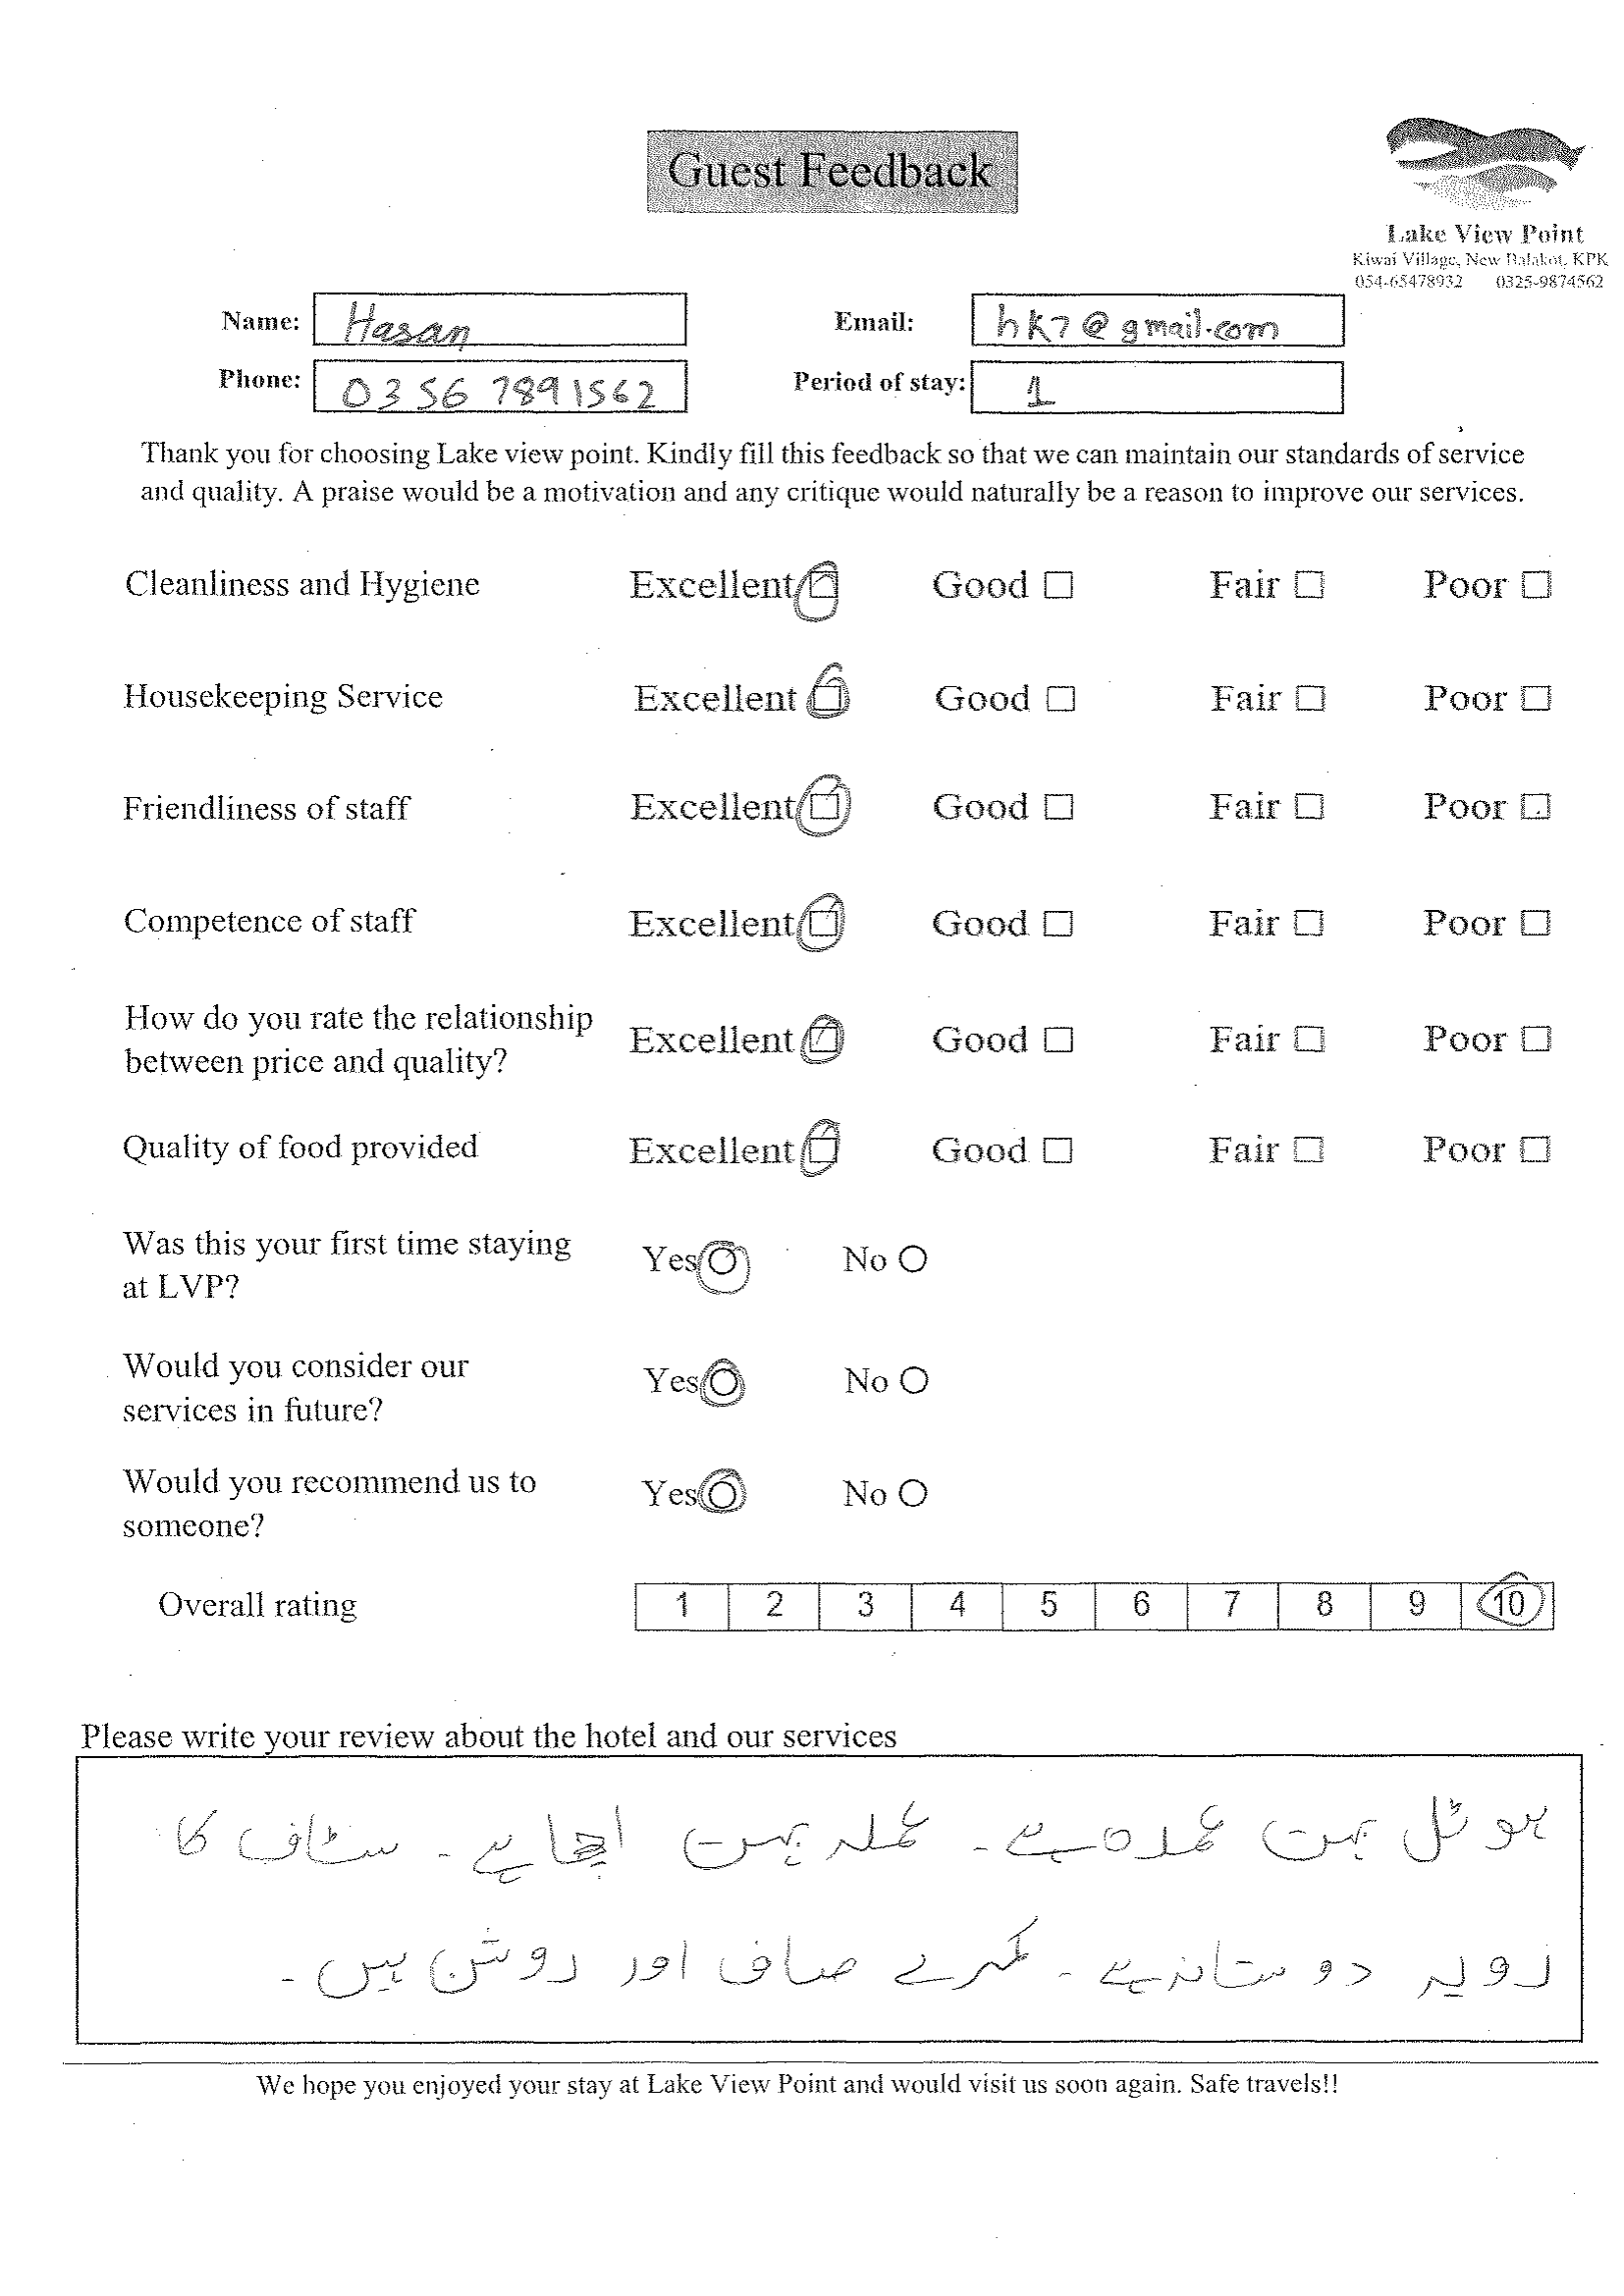

In [14]:
img = cv2.imread("uploads/form8.png")
im.fromarray(img)

### Making inference on the form

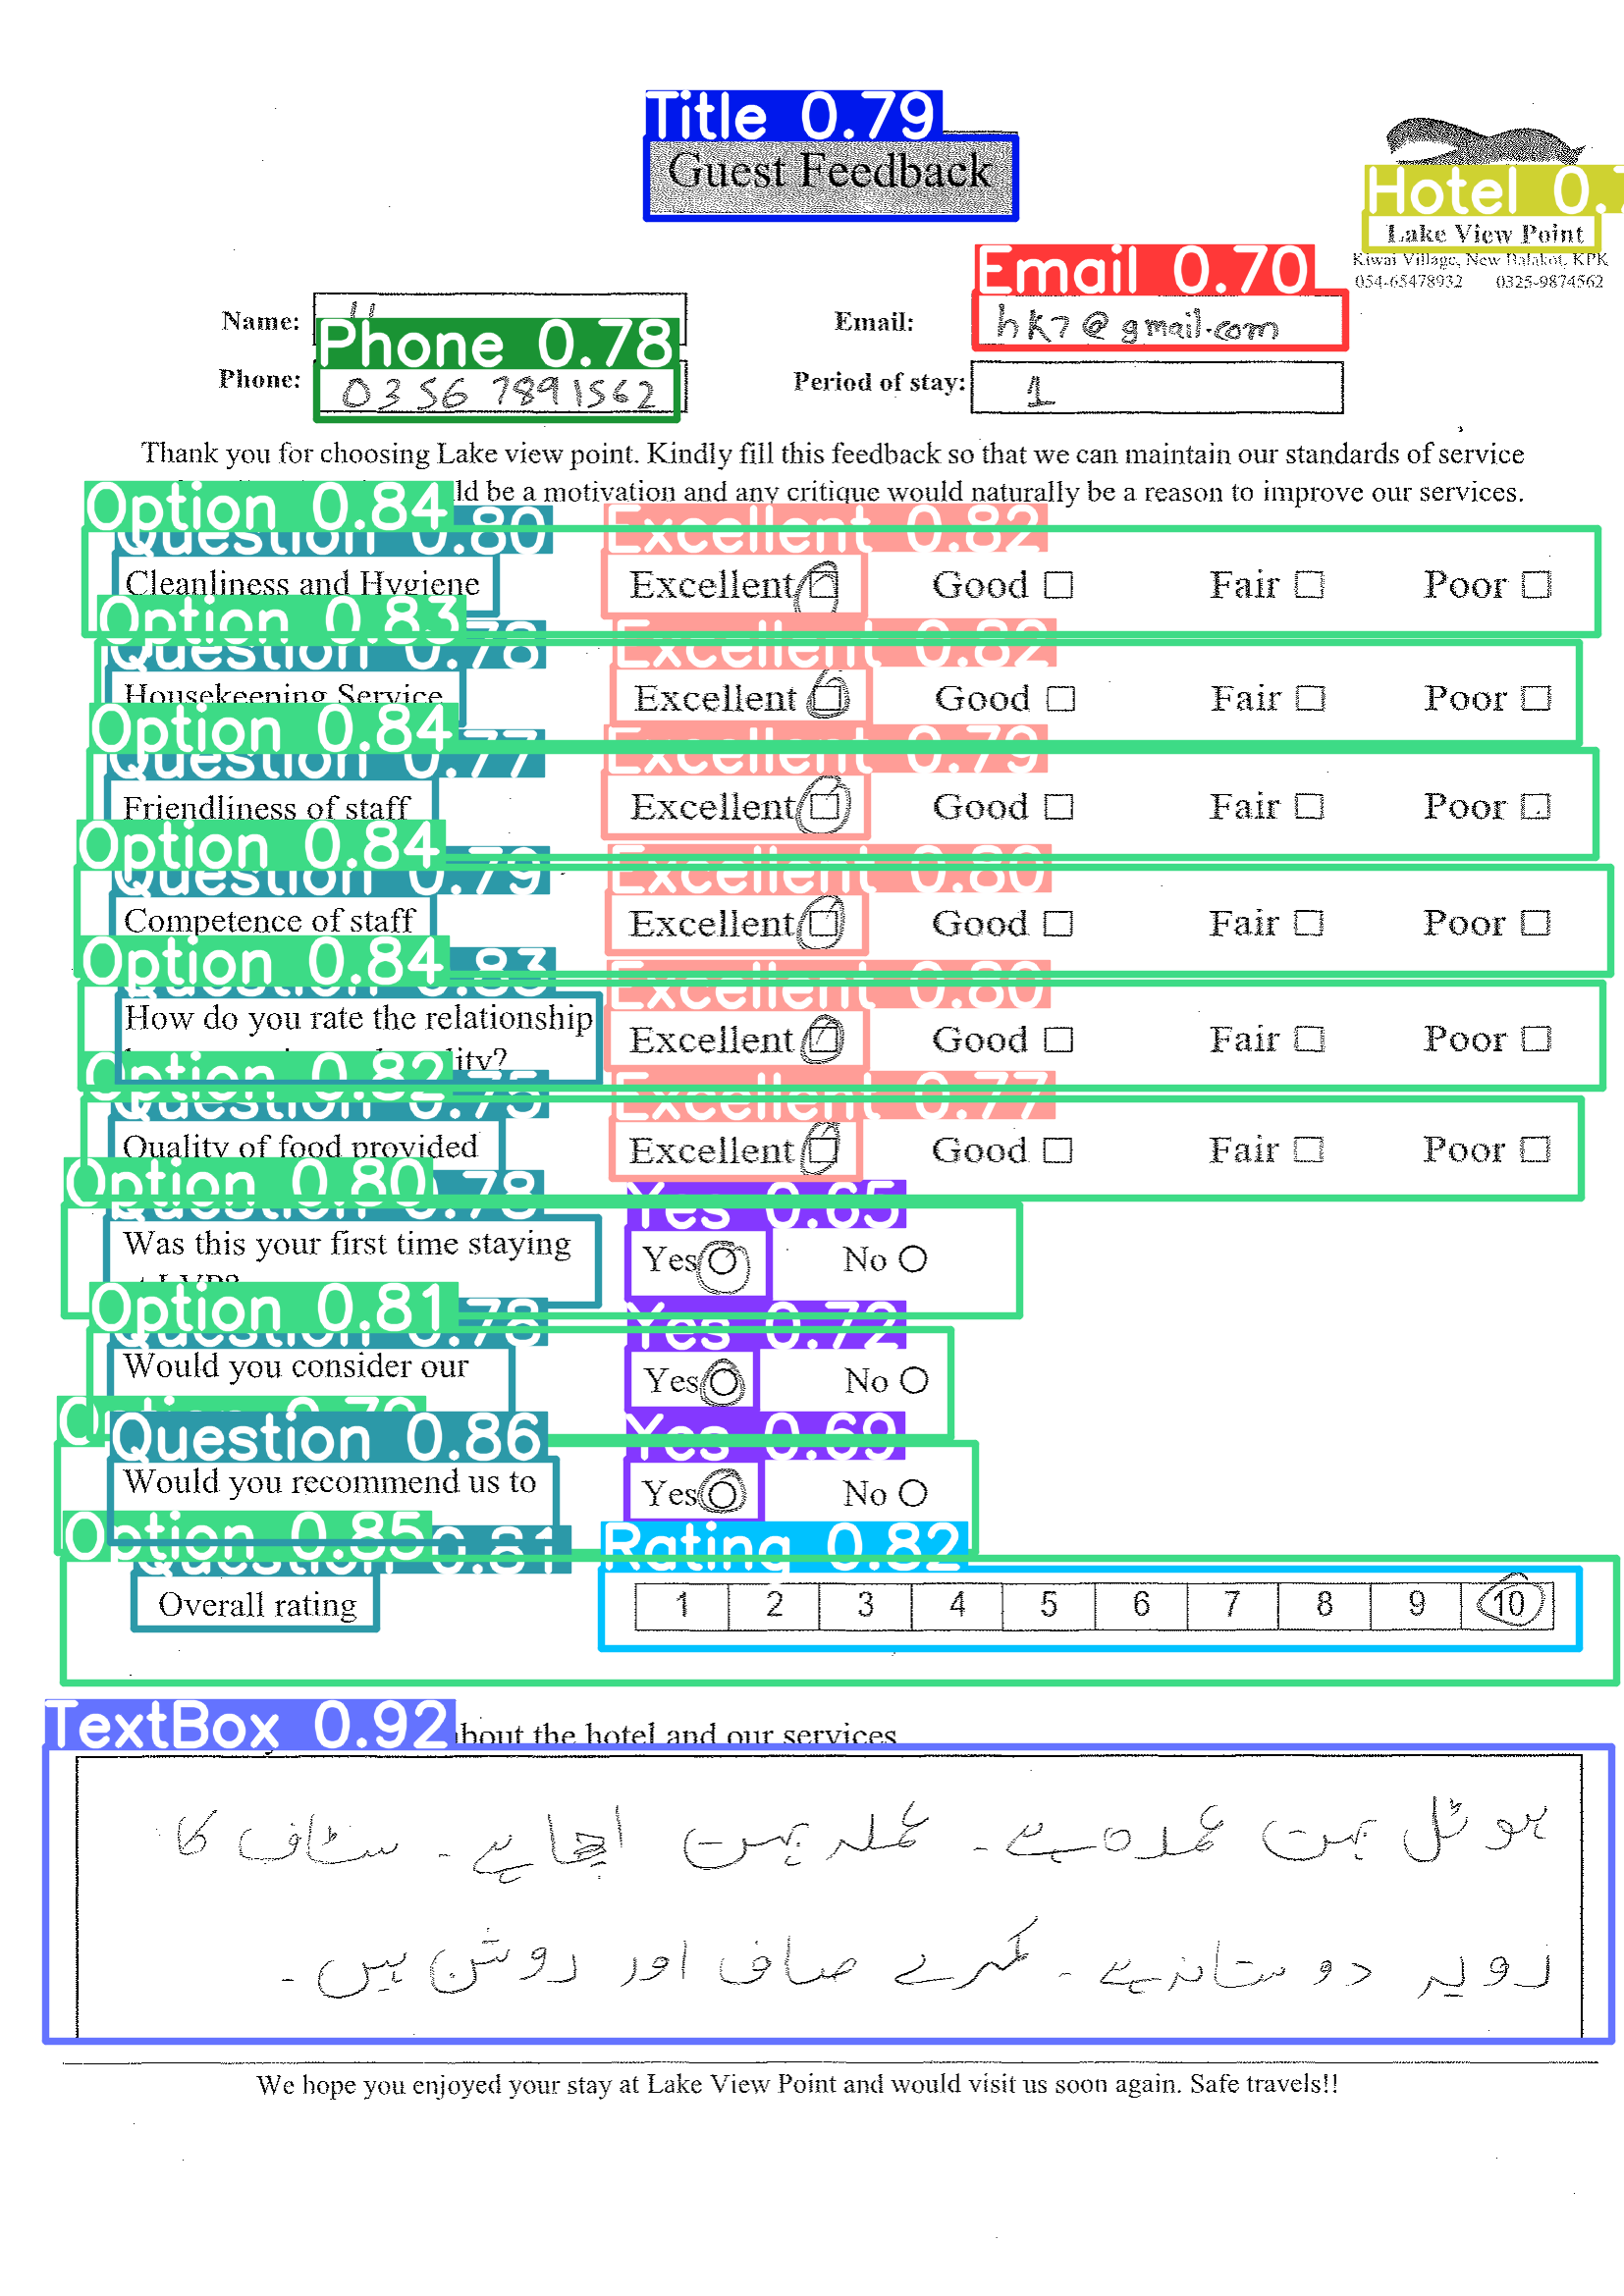

In [15]:
img2 = img.copy()
results = model_FormYOLO(img2)
results.show()

### Seprating the structured and unstructured part of the form 

In [16]:
#Converting the results of yolo infernce on the form into a dataframe
results = results.pandas().xyxy[0].sort_values('ymin')

### Extracting data from the structured part of the form

In [17]:
#Extracting the Question images and The Responses of user
Questions_img, Responses_text = multiChoiceExtracter(img, results)

In [18]:
Responses_text

['Excellent',
 'Excellent',
 'Excellent',
 'Excellent',
 'Excellent',
 'Excellent',
 'Yes',
 'Yes',
 'Yes',
 'Rating']

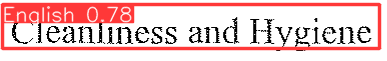

Cleanliness and Hygiene


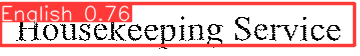

Housekeeping Service.


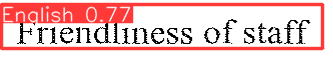

Friendliness of staff.


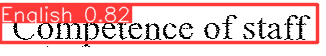

Competence of staff


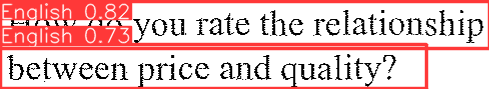

How do you rate the relationship between price and quality?


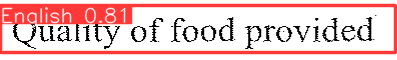

Quality of food provided.


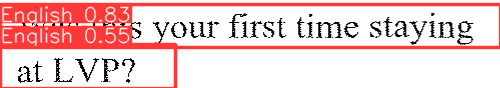

Was this your first time staying. at LVP? '


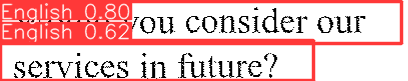

Would you consider our services in future?


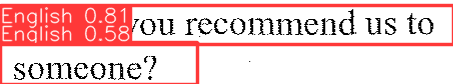

Would you recommend us to someone?


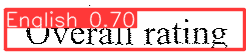

Overall rating.


In [19]:
#Extracting the text in question images
Questions = []
for q_img in Questions_img:
    q_results = model_LineYOLO(q_img)
    q_results.show()
    q_results = q_results.pandas().xyxy[0].sort_values('ymin')
    q_text = extract_questions(q_img,q_results)
    q_text = ' '.join(q_text)
    Questions.append(q_text)
    print(q_text)

In [20]:
#Putting Questions and user responses in a dataframe 
Questions_df = pd.DataFrame()
Questions_df['Questions'] = Questions
Questions_df['Responses'] = Responses_text

In [21]:
Questions_df

,Questions,Responses
0,Cleanliness and Hygiene,Excellent
1,Housekeeping Service.,Excellent
2,Friendliness of staff.,Excellent
3,Competence of staff,Excellent
4,How do you rate the relationship between price...,Excellent
5,Quality of food provided.,Excellent
6,Was this your first time staying. at LVP? ',Yes
7,Would you consider our services in future?,Yes
8,Would you recommend us to someone?,Yes
9,Overall rating.,Rating


In [22]:
#Extracting the rating line and textbox image
textbox_img,rating_scale = imageExtractor(img, results)

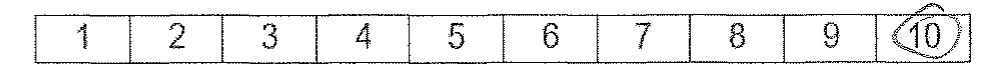

In [23]:
im.fromarray(rating_scale)

In [24]:
#Digtizing the user rating and storing it into a the Questions and Responses dataframe
Rating_num = model_ScaleYOLO(rating_scale)
Rating_df = Rating_num.pandas().xyxy[0]
Rating = Rating_df['name'][0]
Questions_df['Responses'] = Questions_df['Responses'].replace('Rating', str(Rating))

In [25]:
Questions_df

,Questions,Responses
0,Cleanliness and Hygiene,Excellent
1,Housekeeping Service.,Excellent
2,Friendliness of staff.,Excellent
3,Competence of staff,Excellent
4,How do you rate the relationship between price...,Excellent
5,Quality of food provided.,Excellent
6,Was this your first time staying. at LVP? ',Yes
7,Would you consider our services in future?,Yes
8,Would you recommend us to someone?,Yes
9,Overall rating.,10


### Extracting data from the unstructured part of the form

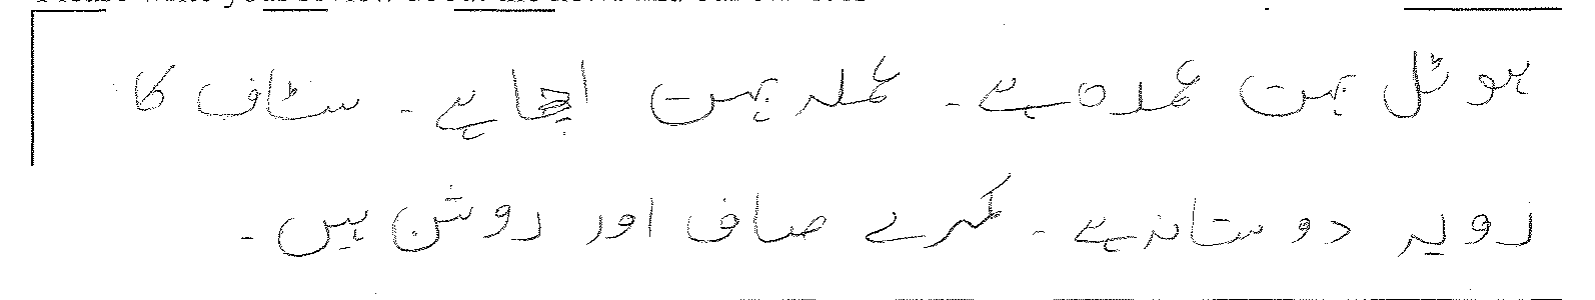

In [26]:
im.fromarray(textbox_img)

In [27]:
lines = model_LineYOLO(textbox_img) 

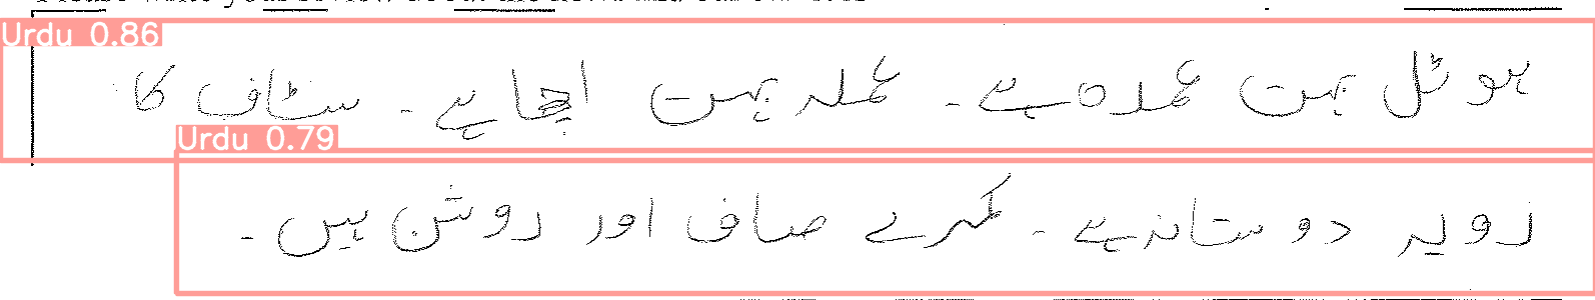

In [35]:
lines.show()

In [34]:
df_lines = lines.pandas().xyxy[0].sort_values('ymin')

In [28]:
df_lines

,xmin,ymin,xmax,ymax,confidence,class,name
0,0.000000,20.796623,1595.0,160.536865,0.857133,1,Urdu
1,176.866592,150.139786,1595.0,293.295013,0.791207,1,Urdu


In [29]:
#Extracting each line from the Textbox image
Text_images = []
for index, row in df_lines.iterrows():
    y_min = int(row["ymin"])
    y_max = int(row["ymax"])
    x_min = int(row["xmin"])
    x_max = int(row["xmax"])
    language = row["name"]
    temp = textbox_img[y_min:y_max  , x_min:x_max]
    Text_images.append(temp)

In [32]:
#Extracting the text in question images
Handwritten_Text = []
for t_img in Text_images:
    if language == 'English':
        t_img = remove_noise(t_img)
        t_img = remove_cutoutwords(t_img)
        temp_text = get_Eng_text(t_img)
        Handwritten_Text.append(temp_text)
    if language == 'Urdu':
        temp_text = Urdu_OCR(t_img)
        Handwritten_Text.append(temp_text)

if language == 'English':
    Handwritten_Text = ' '.join(Handwritten_Text) 
if language == 'Urdu':
    temp = ''
    for item in Handwritten_Text:
        temp += ' '.join(item)
    Handwritten_Text = temp


1/1 [==============================] - 0s 111ms/step


In [33]:
Handwritten_Text

'ہوٹل بت عمدہ ہے۔ عحملہ بہت اچھا ہے۔سٹاف کاارویہ دوستانہ ہے۔کمرے صاف اور روشن ہیں۔'